# Optimizing Permutations
When using Evolutionary Algorithms, one particularly important aspect of applying such an EA is the choice of **encoding**. In many cases the encoding used is trivial, for example a mapping from positions on a discrete string to the variables used within evaluation, or similarly for continuous variables. Such encodings are commonplace, and you have already (potentially unknowingly) encountered them.

The right encoding can however provide significant benefits to the performance of an EA! Specific encodings can be used to avoid infeasible solutions by construction, bias the search space towards regions of interest, or allow for better & more effective recombination. In this assignment we utilize various encodings (and crossover operators) to investigate their applicability to a particularly common (yet constrained) search space: Permutations.

Permutations are used to define sequences, orderings of preference, or unique one-to-one mappings. If you ever had a problem that takes such a input, we generally use a permutation to describe them. The trivial way to 'encode' permutations is a discrete search space, assigning a value 1 through the string length for each position. This approach does however not deal with the uniqueness constraint. The search space therefore also includes invalid solutions.

In this assignment we instead investigate different approaches, each with their own benefits and downsides. One of these approaches is to require a solution to always be a valid permutation, requiring our operators to be modified to preserve this property. Alternatively, we use the Random Key encoding which uses a string of continuous variables as encoding, with the encoded permutation being the order that sorts them.

> **Note!** Have you used poetry to set-up the virtualenv? There are a few dependencies that should be present
> before running the code within this notebook. As of writing these are `numpy`, `matplotlib`, `pandas` and `tsplib95`.
> Installing poetry will automate this, and provide you with dependencies & corresponding versions that have
> been verified to work. Install poetry (for example) using `pip install poetry` or follow the instructions
> at https://python-poetry.org/.
> Running `poetry install` followed by `poetry shell` should provide you with a venv with all dependencies
> present.

## Problems

### Travelling Salesperson (TSP)
Imagine being a delivery driver. Given a set of places you want to deliver a package to, you would likely want to minimize the distance travelled in order to deliver these packages. Every package needs to be delivered once, and we need to return where we started. Given a distance matrix $D$, and an ordering of deliveries $s$ of length $\ell$, the total distance travelled (to be minimized) is as follows:
$$
d(s) = D_{s_\ell,s_1} + \sum_{i = 1}^{\ell - 1}{D_{s[i],s[i+1]}}
$$

For instances, take a look at [TSPLIB](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/), optima (for reference) can be found [here](http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/STSP.html).

Note that some instances are based on a distance measure with coordinates, allowing you to plot them, like the instance below:

In [3]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# This library supports the various instances from TSPLIB (from coordinates to fully explicit matrices)
from permutationsga.tsp import TSP
import tsplib95 as tsp


In [4]:
# Download an example instance and decompress it
!curl -O http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/berlin52.tsp.gz
!gzip -d berlin52.tsp.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   472  100   472    0     0   7122      0 --:--:-- --:--:-- --:--:--  7261


<AxesSubplot:xlabel='0', ylabel='1'>

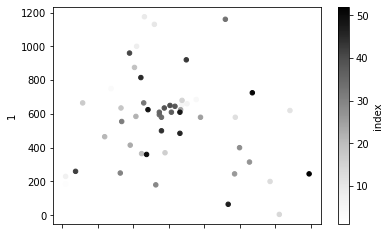

In [5]:
# Load and plot the coordinates
tsp_berlin52 = tsp.load("./berlin52.tsp")
coords_df = pd.DataFrame(tsp_berlin52.node_coords).transpose().reset_index()
coords_df.plot(x=0, y=1, c="index", kind='scatter')

You may notice that the ordering of places by index may not be the best ordering for visiting them. Can you find a better one?

In [6]:
# Download and unpack all of the TSP instances (and gitignore for good measure)
!mkdir instances
!echo * > instances/.gitignore
!mkdir "instances/tsp"
!curl http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/tsp/ALL_tsp.tar.gz -o instances/tsp/tsplib_instances.tar.gz
!cd instances/tsp && echo "*" > .gitignore && tar -xzf tsplib_instances.tar.gz

A subdirectory or file instances already exists.
A subdirectory or file instances/tsp already exists.
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  2 1977k    2 50232    0     0   294k      0  0:00:06 --:--:--  0:00:06  293k
100 1977k  100 1977k    0     0  1560k      0  0:00:01  0:00:01 --:--:-- 1560k
100 1977k  100 1977k    0     0  1560k      0  0:00:01  0:00:01 --:--:-- 1560k


### Quadratic Assignment Problem (QAP)
A different kind of problem, which can also be represented by a permutation is the Quadratic Assignment Problem (QAP). Rather than an ordering the permutation in the QAP, as the name implies, is a one-to-one assignment. Specifically, given two matrices $A$ and $B$, find an assignment $s$ of length $\ell$ such that the cost (to be minimized) is as follows:

$$
c(s) = \sum_{i = 1}^\ell \sum_{j = 1}^\ell A_{i,j} B_{s[i], s[j]}
$$

An example from literature (and included in [QAPLIB](http://www.mgi.polymtl.ca/anjos/qaplib/inst.html), the dataset you will be using) is the layout of a keyboard [^1]: you only have as many keys as letters, and need to assign each letter to a key (or: each key to a letter).

[^1]: R.E. BURKARD and J. OFFERMANN. Entwurf von Schreibmaschinentastaturen mittels quadratischer Zuordnungsprobleme. Zeitschrift für Operations Research, 21:B121-B132, 1977. 

In [13]:
# Download QAP data & solutions
!mkdir instances
!echo * > instances/.gitignore
!cd instances && mkdir qap
# !curl http://www.mgi.polymtl.ca/anjos/qaplib/data.d/qapdata.tar.gz -o instances/qap/qaplib_instances.tar.gz
# !curl http://www.mgi.polymtl.ca/anjos/qaplib/soln.d/qapsoln.tar.gz -o instances/qap/qaplib_solutions.tar.gz
!cd instances/qap && echo "*" > .gitignore && tar -xzf qaplib_instances.tar.gz && tar -xzf qaplib_solutions.tar.gz

A subdirectory or file instances already exists.
A subdirectory or file qap already exists.


## Evolutionary Algorithms
With the problems introduced, it is time to design approaches to solve them. As stated in the introduction, we do not want our approach to spend a considerable amount of resources trying to satisfy the uniqueness constraint. A significant amount of code has already been written for you. Here are some reference materials, operators or modifiers which are implemented are marked with *(Impl.)*:

- Direct (enforced) encoding: Initialize as a permutation, and preserve this property throughout by using specialized crossovers.
  - **Order Crossover (OX)** (Impl.) -- Davis, Lawrence. "Applying adaptive algorithms to epistatic domains." In IJCAI, vol. 85, pp. 162-164. 1985.
  - **Partially Mapped Crossover (PMX)** (Impl.) -- Goldberg, David E., and Robert Lingle. "Alleles, loci, and the traveling salesman problem." In Proceedings of an international conference on genetic algorithms and their applications, vol. 154, pp. 154-159. Hillsdale, NJ: Lawrence Erlbaum, 1985.
  - **Cycle Crossover (CX)** (Impl.) -- Oliver, I. M., DJd Smith, and John RC Holland. "Study of permutation crossover operators on the traveling salesman problem." In Genetic algorithms and their applications: proceedings of the second International Conference on Genetic Algorithms: July 28-31, 1987 at the Massachusetts Institute of Technology, Cambridge, MA. Hillsdale, NJ: L. Erlhaum Associates, 1987., 1987.
  - **Uniform Ordering Crossover (UOX)** -- Kargupta, Hillol, Kalyanmoy Deb, and David E. Goldberg. "Ordering Genetic Algorithms and Deception." In PPSN, pp. 49-58. 1992.
- Alternative encoding
  - **Random Keys** (Impl.) -- Bean, James C. 1994. ‘Genetic Algorithms and Random Keys for Sequencing and Optimization’. ORSA Journal on Computing 6 (2): 154–60. https://doi.org/10.1287/ijoc.6.2.154.
  - **n-Ball Random Keys** & **Reduced Random Keys** -- Krömer, Pavel, Vojtěch Uher, and Václav Snášel. 2022. ‘Novel Random Key Encoding Schemes for the Differential Evolution of Permutation Problems’. IEEE Transactions on Evolutionary Computation 26 (1): 43–57. https://doi.org/10.1109/TEVC.2021.3087802.
- **+ Inverse** (Impl.) - Note that permutations are a bit special, you can list the cities in the order that you are visiting them, but alternatively, you can encode a solution as an assignment of when each city will be visited, too! This actually leads to a different encoding, with different structural dependencies, and can be combined with any of the aforementioned methods.
  - e.g. Baioletti, Marco, Alfredo Milani, and Valentino Santucci. "Variable neighborhood algebraic differential evolution: An application to the linear ordering problem with cumulative costs." Information Sciences 507 (2020): 37-52.

General Resources
- Davis, Lawrence. "Handbook of genetic algorithms." (1991). -- Contains a listing of some less commonly used crossovers for permutations as well!

## Examples!

In [10]:
# Imports
import gzip  # as some instance files may have been compressed

# Re-import dependencies (in case earlier import was skipped)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# This library supports the various instances from TSPLIB (from coordinates to fully explicit matrices)
import tsplib95 as tsp

from permutationsga.ga import (
    ConfigurableGA,
    RandomPermutationInitialization,
    crossover_ox,
    crossover_cx,
    crossover_pmx,
    TournamentSelection,
    FunctionBasedRecombinator,
    SequentialSelector,
    generate_uniform_indices,
    generate_sequential_indices,
    generate_sequential_wrapping_indices,
    RandomUniformInitialization,
    DifferentialEvolutionRecombinator,
)
from permutationsga.problem import (
    IdenticalDecoder,
    InvPermDecoder,
    RandomKeysDecoder,
    ElitistTracker,
)

from permutationsga.tsp import TSP
from permutationsga.qap import QAP, read_qaplib


In [11]:
# TSP
# problem_base = TSP(tsp.parse(gzip.open("./instances/tsp/berlin52.tsp.gz").read().decode('utf8')))
# QAP
problem_base = QAP(*read_qaplib("./instances/qap/bur26a.dat"))

problem = problem_base

FileNotFoundError: [Errno 2] No such file or directory: './instances/qap/bur26a.dat'

In [4]:
# Add the decoder - permutation encoding
problem_decoder = IdenticalDecoder(problem)   # Identity, if using the permutation directly
# problem_decoder = InvPermDecoder(problem)     # Inverse, if you want to reverse the direction in which the mapping occurs

problem = problem_decoder

In [5]:
# Add the tracker
value_to_reach = None
problem_tracker = ElitistTracker(problem, value_to_reach)
problem = problem_tracker

In [6]:
# GA - Permutation
seed = 42
population_size = 2**10
rng = np.random.default_rng(seed=seed + 1)
l = problem.get_length()


# crossover_fn = crossover_pmx; indices_gen = lambda: generate_sequential_indices(rng, l)
# crossover_fn = crossover_pmx; indices_gen = lambda: generate_uniform_indices(rng, l, 0.5)
# crossover_fn = crossover_ox; indices_gen = lambda: generate_sequential_indices(rng, l)
# crossover_fn = crossover_cx; indices_gen = lambda: rng.integers(0, l - 1, size=1)
crossover_fn = crossover_cx; indices_gen = lambda: generate_uniform_indices(rng, l, 0.05)

initialization = RandomPermutationInitialization(l)
parent_selection = SequentialSelector()
recombinator = FunctionBasedRecombinator(
    indices_gen,
    crossover_fn,
    parent_selection,
    population_size * 2, # Note: double as we are including the previous population
    include_what="population"
)
selection = TournamentSelection()
ga = ConfigurableGA(
    seed, population_size, problem, initialization, recombinator, selection
)


In [25]:
raise Exception("Do not run all the cells, run either the ones above or below!")

Exception: Do not run all the cells, run either the ones above or below!

In [19]:
# Add the decoder - Random Keys
problem = RandomKeysDecoder(problem)    # When using random keys as encoding.

In [31]:
# GA - Random Keys
seed = 42
population_size = 2**10
rng = np.random.default_rng(seed=seed + 1)
l = problem.get_length()
cr = 0.5
f = 0.8

initialization = RandomUniformInitialization(l)
recombinator = DifferentialEvolutionRecombinator(0.5, 0.8)
selection = TournamentSelection(2, 1, shuffle=False) # - as recommended with DE, performs a tournament against its parent.
ga = ConfigurableGA(
    seed, population_size, problem, initialization, recombinator, selection
)


Initialize:

In [7]:
ga.generation()


In [8]:
# Current best & worst
min(s.f for s in ga.population), max(s.f for s in ga.population)

(5645698.0, 6408124.0)

(array([ 14., 103., 189., 252., 222., 117.,  75.,  32.,  13.,   7.]),
 array([5645698. , 5721940.6, 5798183.2, 5874425.8, 5950668.4, 6026911. ,
        6103153.6, 6179396.2, 6255638.8, 6331881.4, 6408124. ]),
 <BarContainer object of 10 artists>)

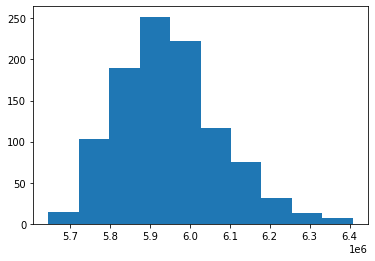

In [9]:
# Histogram
plt.hist([s.f for s in ga.population])

In [10]:
# Changes in best solution found so far:
problem_tracker.elitist_history

,#evaluations,time (s),genotype,phenotype,fitness,is_vtr
0,1,0.000000,"[7, 15, 21, 20, 17, 5, 18, 25, 10, 9, 6, 16, 3...","[7, 15, 21, 20, 17, 5, 18, 25, 10, 9, 6, 16, 3...",6022805.0,False
0,2,0.002113,"[8, 10, 6, 17, 25, 11, 5, 1, 18, 23, 4, 21, 0,...","[8, 10, 6, 17, 25, 11, 5, 1, 18, 23, 4, 21, 0,...",5841038.0,False
0,8,0.006105,"[19, 25, 18, 6, 5, 14, 4, 3, 7, 1, 17, 8, 0, 1...","[19, 25, 18, 6, 5, 14, 4, 3, 7, 1, 17, 8, 0, 1...",5777598.0,False
0,53,0.029109,"[6, 3, 24, 23, 5, 10, 9, 4, 15, 14, 20, 12, 0,...","[6, 3, 24, 23, 5, 10, 9, 4, 15, 14, 20, 12, 0,...",5718685.0,False
0,54,0.031125,"[7, 19, 21, 20, 0, 25, 1, 9, 16, 3, 23, 18, 13...","[7, 19, 21, 20, 0, 25, 1, 9, 16, 3, 23, 18, 13...",5713392.0,False
0,64,0.036136,"[17, 9, 16, 19, 18, 0, 14, 8, 21, 15, 20, 6, 7...","[17, 9, 16, 19, 18, 0, 14, 8, 21, 15, 20, 6, 7...",5703806.0,False
0,280,0.130105,"[18, 16, 25, 7, 9, 0, 13, 15, 1, 2, 14, 12, 4,...","[18, 16, 25, 7, 9, 0, 13, 15, 1, 2, 14, 12, 4,...",5670833.0,False
0,310,0.143105,"[19, 9, 6, 3, 2, 23, 11, 22, 14, 8, 20, 0, 12,...","[19, 9, 6, 3, 2, 23, 11, 22, 14, 8, 20, 0, 12,...",5645698.0,False


Recombine & Select (repeat a few times to see how things evolve!):

In [11]:
ga.generation()
ga.generation()
ga.generation()
ga.generation()
ga.generation()


In [36]:
# Current best & worst
min(s.f for s in ga.population), max(s.f for s in ga.population)

(5478423.0, 5501441.0)

(array([  8.,  22.,   8., 177., 245., 209., 227., 101.,  23.,   4.]),
 array([5516136. , 5536037.9, 5555939.8, 5575841.7, 5595743.6, 5615645.5,
        5635547.4, 5655449.3, 5675351.2, 5695253.1, 5715155. ]),
 <BarContainer object of 10 artists>)

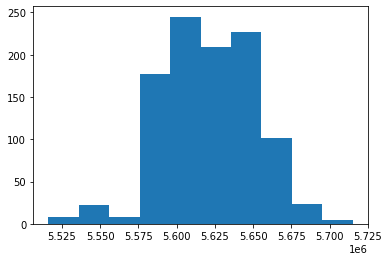

In [12]:
# Histogram
plt.hist([s.f for s in ga.population])

In [13]:
# Changes in best solution found so far:
problem_tracker.elitist_history

,#evaluations,time (s),genotype,phenotype,fitness,is_vtr
0,1,0.000000,"[7, 15, 21, 20, 17, 5, 18, 25, 10, 9, 6, 16, 3...","[7, 15, 21, 20, 17, 5, 18, 25, 10, 9, 6, 16, 3...",6022805.0,False
0,2,0.002113,"[8, 10, 6, 17, 25, 11, 5, 1, 18, 23, 4, 21, 0,...","[8, 10, 6, 17, 25, 11, 5, 1, 18, 23, 4, 21, 0,...",5841038.0,False
0,8,0.006105,"[19, 25, 18, 6, 5, 14, 4, 3, 7, 1, 17, 8, 0, 1...","[19, 25, 18, 6, 5, 14, 4, 3, 7, 1, 17, 8, 0, 1...",5777598.0,False
0,53,0.029109,"[6, 3, 24, 23, 5, 10, 9, 4, 15, 14, 20, 12, 0,...","[6, 3, 24, 23, 5, 10, 9, 4, 15, 14, 20, 12, 0,...",5718685.0,False
0,54,0.031125,"[7, 19, 21, 20, 0, 25, 1, 9, 16, 3, 23, 18, 13...","[7, 19, 21, 20, 0, 25, 1, 9, 16, 3, 23, 18, 13...",5713392.0,False
0,64,0.036136,"[17, 9, 16, 19, 18, 0, 14, 8, 21, 15, 20, 6, 7...","[17, 9, 16, 19, 18, 0, 14, 8, 21, 15, 20, 6, 7...",5703806.0,False
0,280,0.130105,"[18, 16, 25, 7, 9, 0, 13, 15, 1, 2, 14, 12, 4,...","[18, 16, 25, 7, 9, 0, 13, 15, 1, 2, 14, 12, 4,...",5670833.0,False
0,310,0.143105,"[19, 9, 6, 3, 2, 23, 11, 22, 14, 8, 20, 0, 12,...","[19, 9, 6, 3, 2, 23, 11, 22, 14, 8, 20, 0, 12,...",5645698.0,False
0,2067,94.353069,"[15, 16, 25, 2, 7, 14, 1, 21, 0, 3, 13, 17, 4,...","[15, 16, 25, 2, 7, 14, 1, 21, 0, 3, 13, 17, 4,...",5609391.0,False
0,2625,94.587669,"[6, 22, 20, 23, 15, 1, 0, 18, 2, 16, 11, 4, 8,...","[6, 22, 20, 23, 15, 1, 0, 18, 2, 16, 11, 4, 8,...",5594138.0,False


<AxesSubplot:xlabel='#evaluations'>

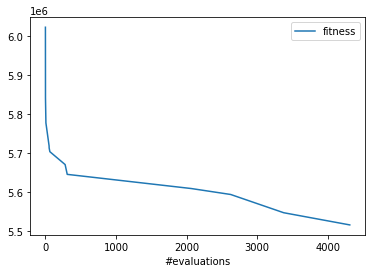

In [18]:
# Convergence graph - 1 run
problem_tracker.elitist_history.plot(x="#evaluations", y="fitness")

In [42]:
# Show genotypes of population
[s.e for s in ga.population]

## Processing multiple runs
An example setup & sequential experiment runner can be found in `example_experiment.py`.

Plotting this data with a convergence graph directly is a bit of an issue however:

In [14]:
data = pd.read_csv("example_experiment_data.csv.gz")

In [15]:
import seaborn as sns

<AxesSubplot:xlabel='#evaluations', ylabel='fitness'>

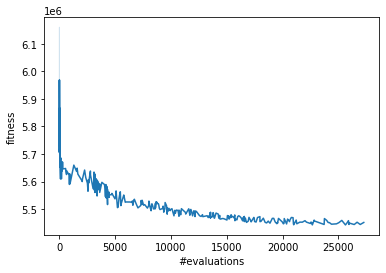

In [16]:
sns.lineplot(data=data, x="#evaluations", y="fitness", errorbar=("pi", 95))

Looks a bit messy, doesn't it? This is due to the fact that the data states "update at evaluation $x$", while the plotting library aggregates at each evaluation $x$. Not all runs necessarily had an update at a given point $x$. This means we are actually interleaving runs, rather than aggregating over them. We resolve this by resampling the runs, such that each run has matching #evaluations when we aggregate.

In [17]:
# First, determine the configurations
aggregating_columns = ["seed"]
unique_configurations = data.groupby(aggregating_columns).size().rename("x").reset_index().drop(columns="x")

# Second, determine the unique #evaluations
unique_evaluations = pd.DataFrame({'#evaluations': data["#evaluations"].sort_values().unique()})

# Construct a list of wanted sampling points by cross join
# Note: order is important, as we'll fill in the missing samples by taking the previous non-missing value
#       and this should be from the same run.
requested_samples = pd.merge(unique_configurations, unique_evaluations, how="cross")
requested_samples

,seed,#evaluations
0,42,1
1,42,2
2,42,3
3,42,4
4,42,5
...,...,...
3175,51,25948
3176,51,26415
3177,51,26672
3178,51,26953


In [38]:
# Resample!
resampled_data = pd.merge(requested_samples, data, how="left", on=aggregating_columns + ["#evaluations"]).ffill()
resampled_data

,seed,#evaluations,time (s),genotype,phenotype,fitness,is_vtr
0,42,1,0.001000,[ 7 15 21 20 17 5 18 25 10 9 6 16 3 0 22 ...,[ 7 15 21 20 17 5 18 25 10 9 6 16 3 0 22 ...,6022805.0,False
1,42,2,0.006001,[ 8 10 6 17 25 11 5 1 18 23 4 21 0 7 19 ...,[ 8 10 6 17 25 11 5 1 18 23 4 21 0 7 19 ...,5841038.0,False
2,42,3,0.006001,[ 8 10 6 17 25 11 5 1 18 23 4 21 0 7 19 ...,[ 8 10 6 17 25 11 5 1 18 23 4 21 0 7 19 ...,5841038.0,False
3,42,4,0.006001,[ 8 10 6 17 25 11 5 1 18 23 4 21 0 7 19 ...,[ 8 10 6 17 25 11 5 1 18 23 4 21 0 7 19 ...,5841038.0,False
4,42,5,0.006001,[ 8 10 6 17 25 11 5 1 18 23 4 21 0 7 19 ...,[ 8 10 6 17 25 11 5 1 18 23 4 21 0 7 19 ...,5841038.0,False
...,...,...,...,...,...,...,...
3175,51,25948,10.553054,[ 7 11 1 10 13 2 25 24 0 6 3 17 19 18 15 ...,[ 7 11 1 10 13 2 25 24 0 6 3 17 19 18 15 ...,5443804.0,False
3176,51,26415,10.553054,[ 7 11 1 10 13 2 25 24 0 6 3 17 19 18 15 ...,[ 7 11 1 10 13 2 25 24 0 6 3 17 19 18 15 ...,5443804.0,False
3177,51,26672,10.553054,[ 7 11 1 10 13 2 25 24 0 6 3 17 19 18 15 ...,[ 7 11 1 10 13 2 25 24 0 6 3 17 19 18 15 ...,5443804.0,False
3178,51,26953,11.932332,[ 7 11 1 10 13 6 25 24 0 20 3 17 19 18 22 ...,[ 7 11 1 10 13 6 25 24 0 20 3 17 19 18 22 ...,5443723.0,False


<AxesSubplot:xlabel='#evaluations', ylabel='fitness'>

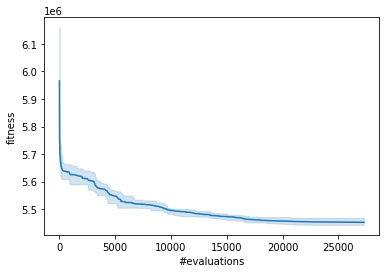

In [39]:
# much better!
sns.lineplot(data=resampled_data, x="#evaluations", y="fitness", errorbar=("pi", 95))

# Assignment
For this assignment you will all have to write a report - in the style of a 'paper' - discussing what you have done, and how, why, etc.

> <br/>
> 💡 Keep notes of what you are doing and why, even before putting it into the report.
> <br/><br/>

Follow the structure in the main document & ensure you have your deliverables ready!